# Introduction

For this week's assignment, we are going to be looking into a dataset from Kaggle [https://kaggle.com/competitions/nlp-getting-started].

This dataset contains 10,000 tweets. And the goal is to train a model that will classify whether or not a particular tweet is about an actual Disaster or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
from string import punctuation
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import keras_tuner as kt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akkshayk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data_path = './nlp-getting-started/train.csv'
test_data_path = './nlp-getting-started/test.csv'
num_words = 10000
n_epochs = 50
batch_size = 32
max_len = 10000

# EDA

In [3]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
train_df.shape

(7613, 5)

In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

As we can see, there are a few rows with null values in the 'keyword' and the 'location' col. So, what we are going to do is to replace the null values with the word "unknown".

In [8]:
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)

/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_54975/1809464961.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('unknown', inplace=True)
/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_54975/1809464961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [9]:
# check null values again
train_df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

# Preprocessing

We are now going to perform some preprocessing steps, by making sure all texts are in lower case, and by removing punctuations, URL and stopwords.

In [10]:
# Lower case for consistency
train_df['text_clean'] = train_df['text'].str.lower()

In [11]:
# Remove punctuation, URLs, etc.
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    return text

train_df['text_clean'] = train_df['text_clean'].apply(clean_text)

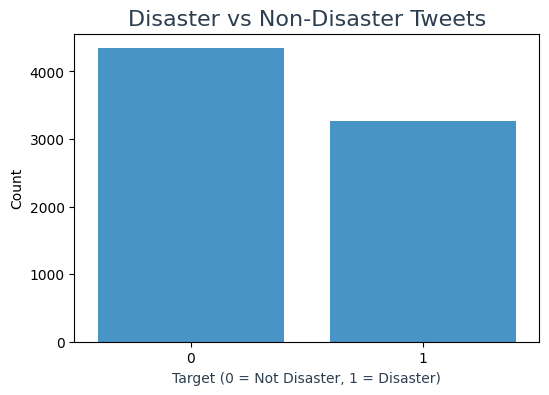

In [12]:
custom_palette = ["#3498DB", "#E74C3C"]
sns.set_palette(custom_palette)

plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Disaster vs Non-Disaster Tweets', color='#2C3E50', fontsize=16)
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)', color='#2C3E50')
plt.ylabel('Count')
plt.show()


As we can see here, there is an imbalance in the dataset, as there are about a 1000 more Non-Disaster tweets compared to actual Disaster tweets.

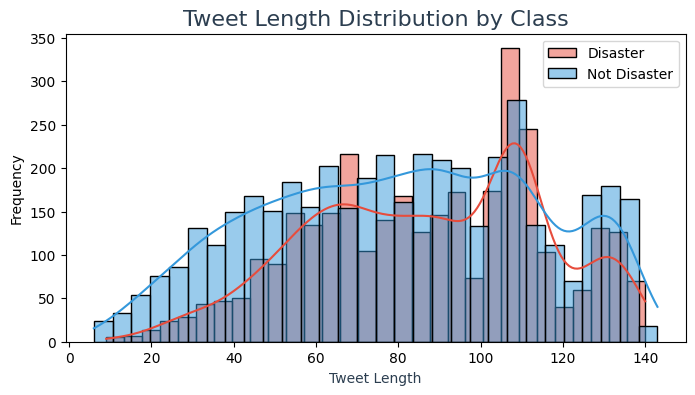

In [13]:
train_df['text_len'] = train_df['text_clean'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(train_df[train_df['target']==1]['text_len'], bins=30, color="#E74C3C", label='Disaster', kde=True)
sns.histplot(train_df[train_df['target']==0]['text_len'], bins=30, color="#3498DB", label='Not Disaster', kde=True)
plt.title("Tweet Length Distribution by Class", color="#2C3E50", fontsize=16)
plt.xlabel("Tweet Length", color="#2C3E50")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_54975/3738910628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")


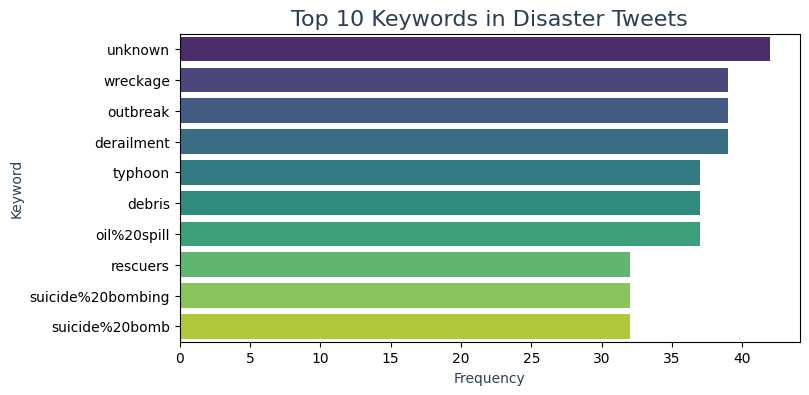

In [14]:
top_keywords = train_df[train_df['target']==1]['keyword'].value_counts().nlargest(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")
plt.title("Top 10 Keywords in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Keyword", color="#2C3E50")
plt.show()


/var/folders/qb/kg2dkg_s7dj4_4419z7q2fj40000gn/T/ipykernel_54975/1569866172.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")


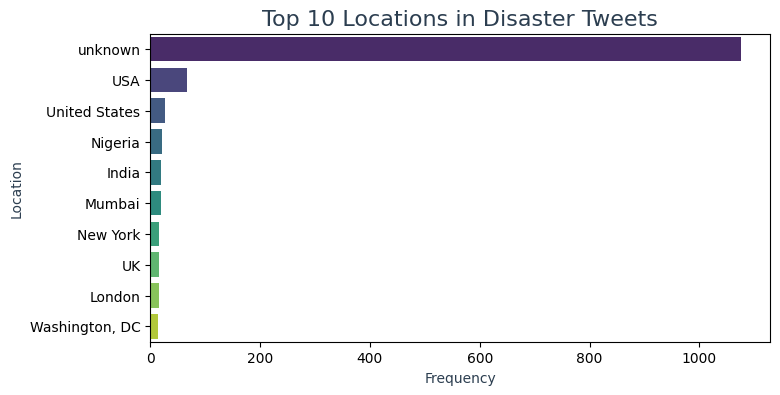

In [15]:
top_keywords = train_df[train_df['target']==1]['location'].value_counts().nlargest(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")
plt.title("Top 10 Locations in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Location", color="#2C3E50")
plt.show()

The location col has a lot of 'unknown' values. So we are going to go ahead and get rid of them.

As part of the next step in preprocessing, we are going to perform stemming, where we cut down words to their basic form. For ex: 'shaking' will become 'shake'

In [16]:
def pre_process(df):
    reviews = []
    stopwords_set = set(stopwords.words("english"))
    ps = PorterStemmer()
    for p in tqdm(df["text"]):
        # convert to lowercase 
        p = p.lower()
        
        # remove punctuation and additional empty strings
        p = ''.join([c for c in p if c not in punctuation])
        reviews_split = p.split()
        reviews_wo_stopwords = [word for word in reviews_split if not word in stopwords_set]
        reviews_stemm = [ps.stem(w) for w in reviews_wo_stopwords]
        p = ' '.join(reviews_stemm)
        reviews.append(p)
    return reviews

train_df['text_pp'] = pre_process(train_df)
test_df['text_pp'] = pre_process(test_df)

100%|██████████| 3263/3263 [00:00<00:00, 16889.72it/s]


In [17]:
# compare the same phrase before and after pre-processing
print('Phrase before pre-processing: ', train_df['text'][0])
print('Phrase after pre-processing: ', train_df['text_pp'][0])

Phrase before pre-processing:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Phrase after pre-processing:  deed reason earthquak may allah forgiv us


In [18]:
X = train_df["text_pp"]
y = train_df["target"]

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_raw = test_df["text_pp"]

## Word Embedding

In [19]:
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_val_seq = tokenizer.texts_to_sequences(X_val_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Dynamically choose max_len (90th percentile of lengths)
sequence_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(sequence_lengths, 90))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Models

We are going to be looking at 2 different models for this particular dataset. We are also going to be performing some hyperparameter tuning, to find the best model and best params.

Models to be used:
1. Bidirectional LSTM
2. Bidirectional 2xGRU

We are going to be tuning the following hyperparameters:
1. Hidden Size
2. Dropout

### Bidirectional LSTM

In [20]:
# Define a model-building function
def build_lstm_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=64, input_length=max_len))
    model.add(
        Bidirectional(
            LSTM(
                units=hp.Choice('units', values=[64, 128]),  # Hidden size
                dropout=hp.Choice('dropout', values=[0.3, 0.5]),  # Dropout rate
                recurrent_dropout=hp.Choice('dropout', values=[0.3, 0.5]),
                return_sequences=False
            )
        )
    )
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [21]:
# Set up tuner
lstm_tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=4,  # 2 hidden_sizes × 2 dropout_rates = 4 combinations
    directory='lstm_tuner',
    project_name='lstm_tuning'
)

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Perform search
lstm_tuner.search(X_train_pad, y_train,
             epochs=n_epochs,
             batch_size=batch_size,
             validation_data=(X_val_pad, y_val),
             callbacks=[early_stop, reduce_lr],
             verbose=1)

Trial 4 Complete [00h 00m 39s]
val_accuracy: 0.7964543700218201

Best val_accuracy So Far: 0.813525915145874
Total elapsed time: 00h 01m 51s


In [23]:
# Get the best model
best_lstm_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Hidden Units: {best_lstm_hps.get('units')}
- Dropout Rate: {best_lstm_hps.get('dropout')}
""")


Best hyperparameters:
- Hidden Units: 128
- Dropout Rate: 0.5



In [24]:
# Build the model with the best hyperparameters
best_lstm_model = lstm_tuner.hypermodel.build(best_lstm_hps)

# Print the model architecture
#best_lstm_model.summary()

We have a best validation accuracy of 0.814. Let's now train our next model, and test it out

### Bidirectional 2xGRU

In [25]:
# Define a model-building function for GRU
def build_gru_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=64, input_length=max_len))

    # First GRU layer
    model.add(
        Bidirectional(
            GRU(
                units=hp.Choice('units', values=[64, 128]),  # Hidden size
                return_sequences=True,
                dropout=hp.Choice('dropout', values=[0.3, 0.5]),  # Dropout rate
                recurrent_dropout=hp.Choice('dropout', values=[0.3, 0.5]),
                kernel_regularizer=l2(0.01)  # Regularization
            )
        )
    )

    # Second GRU layer
    model.add(
        Bidirectional(
            GRU(
                units=hp.Choice('units', values=[64, 128]),  # Hidden size
                dropout=hp.Choice('dropout', values=[0.3, 0.5]),
                recurrent_dropout=hp.Choice('dropout', values=[0.3, 0.5]),
                kernel_regularizer=l2(0.01)
            )
        )
    )

    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [26]:
# Set up tuner
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_accuracy',
    max_trials=4,  # 2 hidden_sizes × 2 dropout_rates = 4 combinations
    directory='gru_tuner',
    project_name='gru_tuning'
)

In [27]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Perform search
tuner_gru.search(X_train_pad, y_train,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_data=(X_val_pad, y_val),
                 callbacks=[early_stop, reduce_lr],
                 verbose=1)

Trial 4 Complete [00h 00m 55s]
val_accuracy: 0.8030203580856323

Best val_accuracy So Far: 0.8115561604499817
Total elapsed time: 00h 07m 03s


In [28]:
# Get the best hyperparameters
best_hps_gru = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Hidden Units: {best_hps_gru.get('units')}
- Dropout Rate: {best_hps_gru.get('dropout')}
""")


Best hyperparameters:
- Hidden Units: 64
- Dropout Rate: 0.5



In [29]:
# Build the model with the best hyperparameters
best_gru_model = tuner_gru.hypermodel.build(best_hps_gru)

# Print the model architecture
#best_gru_model.summary()

## Observation

GRU has a best validation accuracy of 0.812, while the LSTM has a best validation accuracy of 0.814.

They are pretty evenly matched. But since the LSTM model is slightly better, we are going to use that for our final model.

In [33]:
best_lstm_model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

history_lstm = best_lstm_model.fit(X_train_pad, y_train,
                                   epochs=n_epochs,  # you can adjust epochs if needed
                                   batch_size=batch_size,
                                   validation_data=(X_val_pad, y_val),
                                   callbacks=[early_stop, reduce_lr])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6129 - loss: 0.6495 - val_accuracy: 0.7754 - val_loss: 0.4774 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8158 - loss: 0.4240 - val_accuracy: 0.7945 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8593 - loss: 0.3466 - val_accuracy: 0.8043 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8639 - loss: 0.3412 - val_accuracy: 0.8063 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8743 - loss: 0.3069 - val_accuracy: 0.7978 - val_loss: 0.4547 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8929 - loss: 0.2755 - val_accuracy: 0.7919 - val_loss: 0.4898 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8983 - loss: 0.

In [37]:
best_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 15, 64)         │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,675,780 (6.39 MB)

 Trainable params: 837,889 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 837,891 (3.20 MB)

In [35]:
def plot_evaluation(history):

    plt.figure(figsize=(18, 5))
    
    # accuracy
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle="dashed")
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linestyle="dashed")
    plt.plot(history.history['val_loss'], label='Val Loss', color='#1f77b4')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.show()

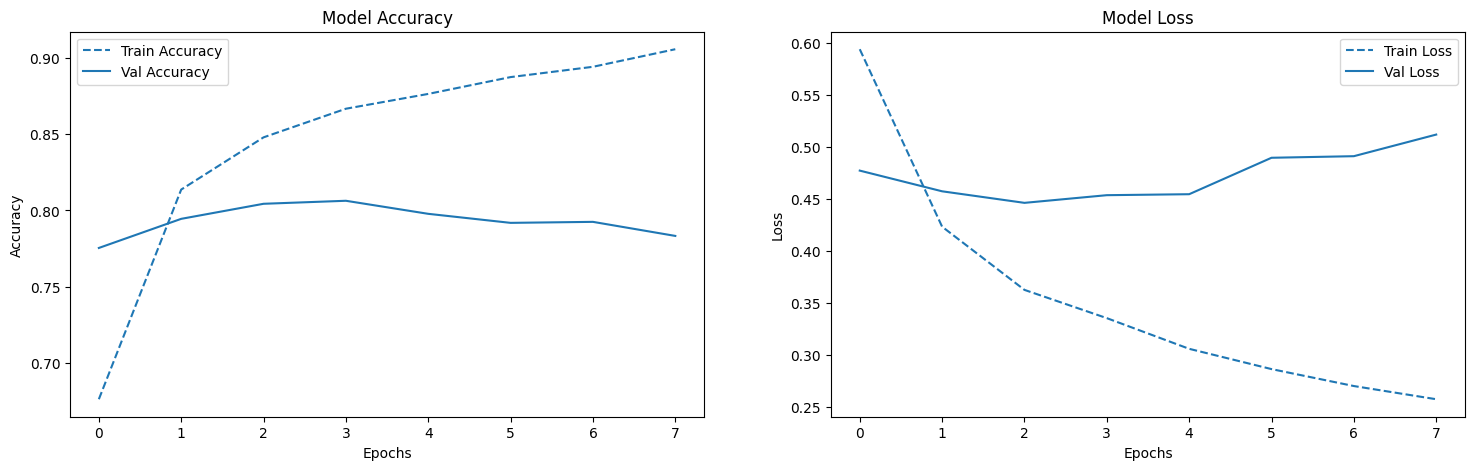

In [38]:
plot_evaluation(history_lstm)

In [39]:
# Generate predictions using the best LSTM model
predictions_lstm = best_lstm_model.predict(X_test_pad).round().astype(int).reshape(-1)

# Create a DataFrame for the submission
submission_best_model = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_lstm
})

# Save the submission to a CSV file
submission_best_model.to_csv('submission_best_model.csv', index=False)

# Display the first few rows of the submission
submission_best_model.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


We got a score of 0.80355 for our best model, when we submitted this to Kaggle.

This tells us that is model is pretty decent, and is not overfitting or underfitting.

# Final Thoughts
This was a very fun project to work on. I got to get my hands dirty and learn a lot about the NLP process, as well as LSTMs and GRUs.

I think the key here was the hyperparameter tuning, which actually helped us understand how the models perform under various parameters, and what each of these parameters control.

### Things to Improve
1. We could try to tune more hyperparameters, and maybe even more values for the existing parameters we tested out in this assignment
2. We can try other models
3. We can potentially try this in a real world scenario and test this out. That would be the actual real test for our models.